# Khipu Practical 2B Extra
# Transformer for Language Modeling

# GENERAL TODOs:

- Motivate Language Modeling, tell the differences 

A **Language Model** is a system that computes the probability of the next word given the words so far, typically using a parametric model $P_\theta(x_t \mid x_0,\cdots,x_{t-1})$ with parameters $\theta$.

[BERT paper](https://arxiv.org/abs/1810.04805)
[GPT-2 paper](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)




# Prelim: Redefine the symbols we've seen

In [0]:
#@title Load Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [0]:
#@title vocab_lookup
NO_SPACING = " ,.';:?¿"

def vocab_lookup(vocab, indices, eos_symbol='</s>'):
  "Lookup the indices given by the model"
  symbols = []
  for idx in indices:
      sym = vocab.itos[idx].encode('utf8')
      # EOS symbol.¿
      if sym == eos_symbol: break
      if symbols and sym not in NO_SPACING:
        sym = ' ' + sym
      symbols.append(sym)
  return ''.join(symbols)

In [0]:
#@title Auxiliary Functions

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


class SimpleLossCompute(object):
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)

        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens.float())
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def make_std_mask(tgt, pad):
    "Create a mask to hide padding and future words."
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(
        subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return tgt_mask

class Batch(object):
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    

In [0]:
#@title Sublayer Connecton & LayerNorm

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [0]:
#@title Varying Rate Optimizer
class VaryingRateOpt(object):
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

In [0]:
#@title Positional Encoding
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [0]:
#@title Embeddings
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [0]:
#@title Positionwise Feedforward Layer
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [0]:
#@title MultiHeadedAttention
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [0]:
#@title Label Smoothing

class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [0]:
#@title Rebatch function
def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    # src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src, trg = batch.text.transpose(0, 1).cuda(), batch.target.transpose(0, 1).cuda()
    return Batch(src, trg, pad_idx)

# Model Architecture

To build our home-made version of the GPT-2 model, we only to remove any reference to the Encoder from the original Transformer model ([link to the other notebook](http)).

In [0]:
# Rewrite of EncoderDecoder class
class DecoderOnlyModel(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, decoder,  tgt_embed, generator):
        super(DecoderOnlyModel, self).__init__()
        self.decoder = decoder
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, tgt, tgt_mask):
        "Take in and process masked  target sequence."
        return self.decode( tgt, tgt_mask)
     
    def decode(self, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), tgt_mask)

In [0]:
# Rewrite of Decoder class
class DecoderOnlyStack(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(DecoderOnlyStack, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, tgt_mask):
        for layer in self.layers:
            x = layer(x, tgt_mask)
        return self.norm(x)

In [0]:
# Rewrite of DecoderLayer class
class DecoderOnlyLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn,  feed_forward, dropout):
        super(DecoderOnlyLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
 
    def forward(self, x, tgt_mask):
        "Follow Figure 1 (right) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        return self.sublayer[1](x, self.feed_forward)

In [0]:
# Rewrite of make_model function
def make_decoder_only_model( 
    tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    layer = DecoderOnlyLayer(
        size=d_model, self_attn=c(attn), 
        feed_forward=c(ff), dropout=dropout)
    model = DecoderOnlyModel(
        DecoderOnlyStack(layer, N),
        nn.Sequential(
            Embeddings(d_model, tgt_vocab), 
            c(position)),  # tgt_embed
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [0]:
# Rewrite of run_epoch
def run_decoder_only_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.trg, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens.float())
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

# A first example with synthetic data

We can begin by trying out a simple  prediction task. We will train a simple test model with uniformily increasing sequences. 

In [0]:
# learn to predict +1
def data_gen(V, batch, nbatches):
    """Generate sequences of integers increasing by 1,
    starting at a random integer smaller than V."""
    for i in range(nbatches):
        data = torch.from_numpy(
            np.arange(10) + np.random.randint(1,V, size=(batch,1)))
        src = Variable(data, requires_grad=False).cuda()
        tgt = Variable(data, requires_grad=False).cuda()
        yield Batch(src, tgt, 0)

## Training the Model

In [0]:
# Train the simple copy task.                                                                                                                                                            
V = 110
Vmax = V + 9
criterion = LabelSmoothing(size=Vmax, padding_idx=0, smoothing=0.0)
model = make_decoder_only_model(Vmax, N=2).cuda()
model_opt = VaryingRateOpt(
    model_size=model.tgt_embed[0].d_model, factor=1, warmup=400, 
    optimizer=torch.optim.Adam(
        model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
 
for epoch in range(10):
    model.train()
    run_decoder_only_epoch(data_gen(V, 30, 20), model,
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_decoder_only_epoch(
        data_gen(V, 30, 5), model,
        SimpleLossCompute(model.generator, criterion, None)))

Epoch Step: 1 Loss: 5.441467 Tokens per Sec: 4294967295.000000
Epoch Step: 1 Loss: 1.419214 Tokens per Sec: 4294967295.000000
tensor(1.3994, device='cuda:0')
Epoch Step: 1 Loss: 1.652011 Tokens per Sec: 4294967295.000000
Epoch Step: 1 Loss: 0.020362 Tokens per Sec: 4294967295.000000
tensor(0.0092, device='cuda:0')
Epoch Step: 1 Loss: 0.028555 Tokens per Sec: 4294967295.000000
Epoch Step: 1 Loss: 0.000352 Tokens per Sec: 4294967295.000000
tensor(0.0004, device='cuda:0')
Epoch Step: 1 Loss: 0.002928 Tokens per Sec: 4294967295.000000
Epoch Step: 1 Loss: 0.000191 Tokens per Sec: 4294967295.000000
tensor(0.0002, device='cuda:0')
Epoch Step: 1 Loss: 0.001854 Tokens per Sec: 4294967295.000000
Epoch Step: 1 Loss: 0.000140 Tokens per Sec: 4294967295.000000
tensor(0.0001, device='cuda:0')
Epoch Step: 1 Loss: 0.001203 Tokens per Sec: 4294967295.000000
Epoch Step: 1 Loss: 0.000095 Tokens per Sec: 4294967295.000000
tensor(0.0001, device='cuda:0')
Epoch Step: 1 Loss: 0.001267 Tokens per Sec: 4294967

## Predicting new sequences

Different to the Machine Translation notebook, instead of greedily choosing the argmax of the predicted probability distribution of the next word, here we will sample from that distribution. Note more sophisticated decoding methods exist such as [beam search](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/), [top-n sampling](http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture15-nlg.pdf).

In [0]:
def sample_decoding(model,  max_len, start_symbol, seq_len):
    """ Use the model's decoder to predict the next symbol by sampling from the
        model's  output distribution"""    

    # starting rom start_symbol, we'll keep appending to this tensor
    ys = torch.tensor([[start_symbol]]).cuda()
    for i in range(max_len-1):
        y_last = ys[-(seq_len-2):] # make the length of the sequence  what the model was trained for
        out = model.decode(
            Variable(y_last),
            Variable(subsequent_mask(y_last.size(1)).type_as(ys.data)))
        prob = model.generator(out[:, -1])
        prob_np = prob.data[0].cpu().numpy()                          
        prob_np = np.exp(prob_np)/sum(np.exp(prob_np))
        next_word = np.random.choice(len(prob_np), p=prob_np) 
        next_word_tns = torch.tensor([[next_word]], dtype=ys.data.dtype).cuda()
        ys = torch.cat([ys, next_word_tns], dim=1)
    return ys

Starting from a given integer, let's check what the model predicts

In [0]:
model.eval()
start_symbol = 70
print(sample_decoding(model, max_len=10, start_symbol=start_symbol, seq_len=10))

tensor([[70, 71, 72, 73, 74, 75, 76, 77, 78, 79]], device='cuda:0')


# A Real World Language Modelling Example


Now let's build a language model to generate Shakespearian English or Don Quijote's Spanish! A language model is trained to assign high probabilities to sequences of words or sentences that are well formed, and low probabilities to sequences which are not realistic. When the model is trained, one can use it to generate data that is similar to the training data.

In [0]:
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download es

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python2.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python2.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 11.1MB 1.2MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.1.0-cp27-none-any.whl size=11111557 sha256=3c48501b70ed99abcdc82962bf0fff510951af7e63a19aa15ba09b1f98076789
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ta6eb/wheels/cc/ee/c4/68922955901918a9aaa82e828d4f7ee1ccfc861285277e79b7
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python2.7/dist-packages/es_core_news_sm -->
/usr/local/lib/python2.7/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')


## Data Loading
We will load the dataset using torchtext and spacy for tokenization. 

In [0]:
download_and_save_dataset = True

if download_and_save_dataset:
  import urllib2, ssl

  context = ssl._create_unverified_context()

  ## uncomment for Don Quijote
  text_url = 'http://www.gutenberg.org/cache/epub/2000/pg2000.txt'
  start=28142

  ## uncomment for Shakespeare
  # text_url = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'
  # start = 0 


  dataset_raw = urllib2.urlopen(text_url, context=context)
  all_text = dataset_raw.read().decode('utf-8').lower()

  all_text = all_text[start:]

  # we remove the line breaks because they not always correspond to end of sentences.                                                              
  all_text = (
      all_text
      .replace('\r\n',' ')
      .replace('\n', ' ')
      .replace('-', ' - ')) 

  print("Downloaded Text data with {} characters.".format(len(all_text)))
  print("FIRST 500 CHARACTERS: ")
  print(all_text[:500])

  L = len(all_text)

  train = all_text[:int(L*.92)]
  # we'll leave 4% for test and validation
  val = all_text[int(L*.92):int(L*.96)]  
  test = all_text[int(L*.96):]

  with open('train.txt', 'w') as f:
    f.write(train.encode('utf-8'))
  with open('test.txt', 'w') as f:
    f.write(test.encode('utf-8'))
  with open('val.txt', 'w') as f:
    f.write(val.encode('utf-8'))
    

Downloaded Text data with 2103989 characters.
FIRST 500 CHARACTERS: 
en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lantejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. el resto della concluían sayo de velarte, calzas de velludo para las fiestas, con sus pantuflos de lo mesmo, y los días


In [0]:
# For data loading.
from torchtext import data, datasets
load_data = True

if load_data:
    import spacy
    spacy_es = spacy.load('es')
  
    def tokenize_es(text):
        return [tok.text for tok in spacy_es.tokenizer(text)]
   
    # Dataset constants
    MIN_FREQ = 2
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_es, pad_token=BLANK_WORD)
    
    train = datasets.LanguageModelingDataset('train.txt', SRC)
    test = datasets.LanguageModelingDataset('test.txt', SRC)
    val = datasets.LanguageModelingDataset('val.txt', SRC)
            
    SRC.build_vocab(train, min_freq=MIN_FREQ)
    
    # take a look at the vocabulary that was just built:
    print(SRC.vocab.itos[1:20])

['<blank>', u',', u'que', u'y', u'de', u'la', u'a', u'en', u'el', u'.', u'-', u'no', u';', u'los', u'se', u' ', u'con', u'por', u'lo']


The next function creates batches of sequences of a given length for training, validation and testing.

In [0]:
seq_len = 32
train_iter, val_iter, test_iter = data.BPTTIterator.splits(
    (train, val, test),
    batch_size=256,
    bptt_len=seq_len, # this is where we specify the sequence length
    device=0,
    repeat=False,
    shuffle = True)

## Training the System

Now we create our model for language modeling. Remember this is only a Transformer model where we just did away with the Encoder part.

In [0]:
model = make_decoder_only_model(len(SRC.vocab), N=4, dropout=0.2)
model.cuda()


Let's first try the model with random weights to see the kind of random language it generates. The output should be an incoherent list of random words.

In [0]:
model.eval()
                                                                                                                                                                      
start_symbol = np.random.randint(len(SRC.vocab))
out = sample_decoding(model, max_len=seq_len, start_symbol=start_symbol, seq_len=seq_len)
txt = vocab_lookup(SRC.vocab, out[0])
print("Result:\t %s " % (txt))

Result:	 insignias cortesano curiosas íbase parto sustancia visitar diciendo alzar sucesos fealdad estorbar siniestra pisado buenas tropiezo pegar hacienda traemos lascivia lavarse amar bastaba examinase llamado dolorosa caminemos haberle cueros usará retirada contará 



We are now ready to train our language model:

In [0]:
import warnings
warnings.filterwarnings(action='once')


pad_idx = SRC.vocab.stoi["<blank>"]
criterion = LabelSmoothing(
    size=len(SRC.vocab), padding_idx=pad_idx, smoothing=1e-6).cuda()

run_training = True


if run_training:
    model_opt = VaryingRateOpt(
        model_size=model.tgt_embed[0].d_model, factor=1, warmup=1000, 
        optimizer=torch.optim.Adam(
            model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    
    for epoch in range(20):
        model.train()
        run_decoder_only_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model,                   
                  SimpleLossCompute(model.generator, criterion, opt=model_opt))
        model.eval()
        loss = run_decoder_only_epoch(
            (rebatch(pad_idx, b) for b in val_iter), 
            model, 
            SimpleLossCompute(model.generator, criterion, opt=None))
        print('Epoch [%i] Validation loss: %f' % (epoch, loss.item()))

Epoch Step: 1 Loss: 7.948686 Tokens per Sec: 15872.000000
Epoch Step: 51 Loss: 7.009734 Tokens per Sec: 12973.000000
Epoch Step: 1 Loss: 6.839465 Tokens per Sec: 15810.000000
('Validation loss:', 6.836467742919922)
Epoch Step: 1 Loss: 6.917358 Tokens per Sec: 15872.000000
Epoch Step: 51 Loss: 5.862072 Tokens per Sec: 12973.000000
Epoch Step: 1 Loss: 5.813263 Tokens per Sec: 15810.000000
('Validation loss:', 5.79462194442749)
Epoch Step: 1 Loss: 5.949924 Tokens per Sec: 15872.000000
Epoch Step: 51 Loss: 5.365247 Tokens per Sec: 12973.000000
Epoch Step: 1 Loss: 5.328978 Tokens per Sec: 15810.000000
('Validation loss:', 5.301341533660889)
Epoch Step: 1 Loss: 5.519432 Tokens per Sec: 15872.000000
Epoch Step: 51 Loss: 4.919480 Tokens per Sec: 12973.000000
Epoch Step: 1 Loss: 4.981691 Tokens per Sec: 15810.000000
('Validation loss:', 4.949314117431641)
Epoch Step: 1 Loss: 5.163448 Tokens per Sec: 15872.000000
Epoch Step: 51 Loss: 4.569210 Tokens per Sec: 12973.000000
Epoch Step: 1 Loss: 4.71

Once trained we can decode the model to produce a set of random phrases. Note that  in this case, instead of maximizing the probability of the next word, we  randomly sample from the probabity distribution of the next word as estimated by the model.

After some training, you should see phrases that start to look more coherent at a low level, but still are rather incoherent at a high semantic level. 


In [0]:
model.eval()
L = len(SRC.vocab)                                                                                                                                                                       
for _ in range(5):
    start_symbol = np.random.randint(L)
    out = sample_decoding(model, max_len=64, start_symbol=start_symbol, seq_len=seq_len)
    txt = vocab_lookup(SRC.vocab, out[0])
    print( "Result:\t  %s" % (txt))

Result:	  hagan esta <unk> a vuestras cuitas, y a vuestras dádivas, muchas y beneficios por el mundo. y <unk> yo a sus desdichas, le diré cosas que ahora a mis hazañas y alteza a los trabajos, y a sancho a sus golpes por su amo y a mi señora mía  -, aunque pesa en esto sin saberse a
Result:	  encomendándose a dios y a su escudero y al cielo, y a él no se ha de estender la tal naturaleza de la tal mancha, digo, como si las causas de propósito a hurto ! ¡ ea y aun a las manos está vuestra merced !  teresa, que se queda puesto que se usa largo y lo soy yo
Result:	  no le queda sino  - respondió juana -, pero, como yo esté en diste el barbero, habréis hallado en esta vida, señora mía.    - no <unk> a vuesa merced, hija me <unk> aquí presente en éste:¿ cómo los vocablos, señor, teresa, por aquí los fío tan al cielo, <unk>?
Result:	  alcanzase en voluntad que he echado, en querer <unk> ni con estas calles, y si el de calabazadas, que a estas últimas palabras altisidora, al son de clori, para

**Question:** What can be done to take this model to the next level and produce extremely realistic phrases like the ones generated by [GPT-2](https://openai.com/blog/better-language-models/)? Would running many more iterations help? If not, why not?


Here are a couple online demos where you can play around with very advanced models: [demo](https://transformer.huggingface.co/) by the Hugging Face team and [demo](https://gpt2.apps.allenai.org/?text=Who%20is%20) by the Allen Institute, where the probabilities of the next word are displayed.

## Attention Visualization

> Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention 

('Decoder Self Layer', 1)


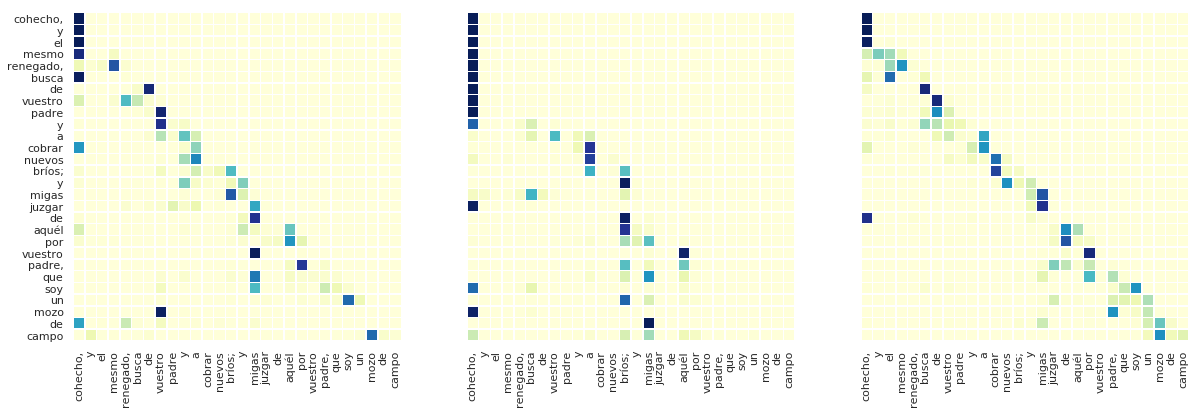

('Decoder Self Layer', 3)


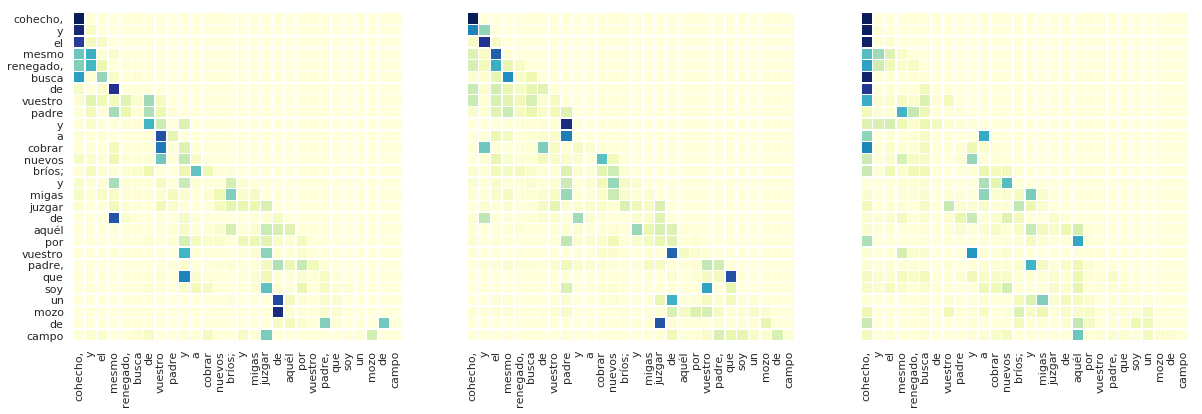

In [0]:
#@title Decoder Attention Visualization

words = txt.split()

seaborn.set(font_scale=1.0)
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=[xx for xx in x], square=True, yticklabels=[yy for yy in y], vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax, cmap="YlGnBu", linewidths=.5)
    
    
for layer in range(0, 4, 2):
    fig, axs = plt.subplots(1,3, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(3): # index of attention head 
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(words), :len(words)].cpu(), 
            words, words if h ==0 else [], ax=axs[h])
    plt.show()
